In [1]:
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.spatial.distance
import scipy.ndimage.filters
import copy
from matplotlib import animation
import matplotlib as mpl
from pylab import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import font_manager
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.pyplot import cm
from matplotlib.cm import ScalarMappable

# Edit the font, font size, and axes width
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['lines.linewidth'] = 2
#mpl.rcParams['font.family'] = 'Sans'
#mpl.rcParams['font.family'] = 'Helvetica'
plt.rcParams['font.size'] = 9
plt.rcParams['axes.linewidth'] = 2

%matplotlib inline

import matplotlib.font_manager as fm


font_dir = ['../extra/fonts/helvetica/']
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)
# Collect all the font names available to matplotlib
font_names = [f.name for f in fm.fontManager.ttflist]
#print(font_names)
mpl.rcParams['font.family'] = 'Helvetica'
figure_dir = 'nat_comm'
os.makedirs(figure_dir, exist_ok=True)

def rate_of_force(F, dx, k0, kbT):
    """
    Calculate the values of the function k = k0 * exp(F * dx / kbT).

    Parameters:
    F (numpy.ndarray): Input array.
    dx (float): Value of dx.
    k0 (float): Value of k0.
    kbT (float): Value of kbT constant.

    Returns:
    numpy.ndarray: Array containing the calculated function values.
    """
    F_modified = 0.6022 * F  # convert pN to kj/(mol*nm)
    k = k0 * np.exp(F_modified * dx / kbT)
    return k

def get_B1_0(k_21_0, k_10_0, k_12_0, k_20_0):
    #J_i = S_i*k_i0_0
    #B_i_0 = S_i*k_i0_0
    #B_2_0 =S_2*k_20_0
    B1_0 = (k_21_0*k_10_0)/((k_21_0*k_10_0) + (k_12_0*k_20_0))
    return B1_0

def get_B2_0(k_21_0, k_10_0, k_12_0, k_20_0):
    #J_i = S_i*k_i0_0
    #B_i_0 = S_i*k_i0_0
    #B_2_0 =S_2*k_20_0
    B2_0 = (k_12_0*k_20_0)/((k_12_0*k_20_0)+(k_21_0*k_10_0))
    return B2_0


def get_lam1(k_21,k_20,k_12,k_10):
    b = k_21 + k_20 + k_12 + k_10
    c = k_21*k_10 + k_10*k_20 + k_12*k_20
    lam = (b + np.sqrt(b*b - 4*c))/2
    return lam

def get_lam2(k_21,k_20,k_12,k_10):
    b = k_21 + k_20 + k_12 + k_10
    c = k_21*k_10 + k_10*k_20 + k_12*k_20
    lam = (b - np.sqrt(b*b - 4*c))/2
    return lam

def get_B1_t(B1_0, k_20, lam1, k_21, lam2, t):
    B1_t = ((B1_0*(k_20-lam1)+k_21)*np.exp(-lam1*t)/(lam2-lam1) - (B1_0*(k_20-lam2)+k_21)*np.exp(-lam2*t)/(lam2-lam1))
    return B1_t

def get_B2_t(B2_0, k_10, lam1, k_12, lam2, t):
    B2_t = ((B2_0*(k_10-lam1)+k_12)*np.exp(-lam1*t)/(lam2-lam1) - (B2_0*(k_10-lam2)+k_12)*np.exp(-lam2*t)/(lam2-lam1))
    return B2_t

def Bond_survival(c1, lam1, c2, lam2, t):
    B_t = c1*np.exp(-lam1*t) + c2*np.exp(-lam2*t)
    return B_t

def get_C1(k_21, k_12, B1_0, B2_0,k_20, k_10, lam1, lam2):
    c = (k_21 + k_12 + B1_0*k_20 + B2_0*k_10 - lam1)/(lam2-lam1)
    return c

def get_C2(k_21, k_12, B1_0, B2_0,k_20, k_10, lam1, lam2):
    c = (k_21 + k_12 + B1_0*k_20 + B2_0*k_10 - lam2)/(lam1-lam2)
    return c

def get_tau(c1,c2,lam1,lam2):
    tau = c1/lam1 + c2/lam2
    return tau




In [2]:
F_neg = np.linspace(-22, 0, 50)*-1  # Input array F in pN F has to be positive for fit to work
kbT = 2.494339  # Value of kbT kj/mol at 300 Kelvin

dx_l = [0, 0.3, 0, -3.8]
k0_l = [3.9,0.045,2.7,8.3] #10 20 12 21
colors = ['b', 'r', 'g', 'm']

keys = ['k_10', 'k_20', 'k_12', 'k_21']
k_rates = {}
for i in range(4):
    dx = dx_l[i]
    k0 = k0_l[i]
    # Calculate function values
    k_ij = rate_of_force(F_neg, dx, k0, kbT)
    k_rates[keys[i]]=k_ij
k_rates

{'k_10': array([3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9,
        3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9,
        3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9,
        3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9, 3.9]),
 'k_20': array([0.22142382, 0.21433923, 0.2074813 , 0.2008428 , 0.19441671,
        0.18819622, 0.18217476, 0.17634596, 0.17070366, 0.16524188,
        0.15995486, 0.154837  , 0.14988289, 0.14508729, 0.14044513,
        0.1359515 , 0.13160164, 0.12739096, 0.123315  , 0.11936946,
        0.11555016, 0.11185305, 0.10827424, 0.10480994, 0.10145648,
        0.09821031, 0.09506801, 0.09202625, 0.08908181, 0.08623158,
        0.08347254, 0.08080178, 0.07821648, 0.07571389, 0.07329138,
        0.07094637, 0.0686764 , 0.06647905, 0.06435201, 0.06229302,
        0.06029992, 0.05837058, 0.05650298, 0.05469513, 0.05294512,
        0.05125111, 0.0496113 , 0.04802395, 0.04648739, 0.045     ]),
 'k_12': array([2.

In [3]:
# k at 0 force for each transition
k_10_0 = k0_l[0] 
k_20_0 = k0_l[1]
k_12_0 = k0_l[2]
k_21_0 = k0_l[3]

#bell's models k at pulling force for each transition rate
k_10 = k_rates['k_10']
k_20 = k_rates['k_20']
k_12 = k_rates['k_12']
k_21 = k_rates['k_21']

B1_0 = get_B1_0(k_21_0, k_10_0, k_12_0, k_20_0)
B2_0 = get_B2_0(k_21_0, k_10_0, k_12_0, k_20_0)
print(B1_0, B2_0)


lam1 = get_lam1(k_21,k_20,k_12,k_10)
lam2 = get_lam2(k_21,k_20,k_12,k_10)

print(lam1)
print(lam2)

C_1 = get_C1(k_21, k_12, B1_0, B2_0,k_20, k_10, lam1, lam2)
C_2 = get_C2(k_21, k_12, B1_0, B2_0,k_20, k_10, lam1, lam2)

print(C_1)
print(C_2)

0.9962605604542727 0.0037394395457273437
[ 6.60000001  6.60000001  6.60000001  6.60000002  6.60000003  6.60000005
  6.60000007  6.60000011  6.60000016  6.60000024  6.60000037  6.60000055
  6.60000084  6.60000126  6.6000019   6.60000287  6.60000433  6.60000653
  6.60000985  6.60001487  6.60002243  6.60003384  6.60005107  6.60007705
  6.60011627  6.60017544  6.60026474  6.60039949  6.60060287  6.6009098
  6.60137307  6.60207238  6.60312812  6.60472231  6.6071303   6.61076914
  6.61627171  6.62460099  6.63722821  6.65641461  6.68566641  6.73048981
  6.79968821  6.90768466  7.07886118  7.35595099  7.81635032  8.60173646
  9.96095148 12.28615311]
[0.22142383 0.21433924 0.20748132 0.20084283 0.19441675 0.18819628
 0.18217486 0.17634611 0.17070388 0.16524222 0.15995537 0.15483777
 0.14988405 0.14508904 0.14044778 0.1359555  0.13160768 0.12740008
 0.12332879 0.11939028 0.1155816  0.11190054 0.10834596 0.10491824
 0.10162004 0.09845733 0.09544105 0.09258959 0.08993253 0.08751624
 0.08541243 0.0

In [4]:
tau_vs_force_neg = get_tau(C_1,C_2,lam1,lam2)
tau_vs_force_neg

array([2.00847481, 2.06987197, 2.13329848, 2.1988214 , 2.26651001,
       2.33643583, 2.40867277, 2.48329712, 2.56038762, 2.64002553,
       2.72229463, 2.80728124, 2.89507408, 2.98576418, 3.0794445 ,
       3.17620934, 3.27615335, 3.37936986, 3.48594806, 3.59596846,
       3.70949554, 3.82656576, 3.94716825, 4.07121372, 4.19848458,
       4.32855513, 4.46066475, 4.59351785, 4.7249729 , 4.85156874,
       4.96782853, 5.0652968 , 5.13134981, 5.14805787, 5.09187965,
       4.9357199 , 4.65534003, 4.24075528, 3.70857949, 3.1057879 ,
       2.49741965, 1.94359187, 1.48136005, 1.12116522, 0.85450345,
       0.66417387, 0.53170896, 0.44106855, 0.37974052, 0.33855008])

In [5]:
F_pos = np.linspace(0, 22, 50) 

dx_l_pos = [0.5, 0.7, 0, -2.8]

k0_l = [3.9,0.045,2.7,8.3] #10 20 12 21
colors = ['b', 'r', 'g', 'm']
keys = ['k_10', 'k_20', 'k_12', 'k_21']
k_rates_pos = {}
for i in range(4):
    dx = dx_l_pos[i]
    k0 = k0_l[i]
    # Calculate function values
    k_ij = rate_of_force(F_pos, dx, k0, kbT)
    k_rates_pos[keys[i]]=k_ij
k_rates_pos

{'k_10': array([ 3.9       ,  4.11720436,  4.34650558,  4.58857737,  4.84413097,
         5.11391723,  5.3987288 ,  5.69940251,  6.01682177,  6.35191919,
         6.70567933,  7.0791416 ,  7.47340325,  7.88962269,  8.32902281,
         8.79289463,  9.28260107,  9.79958093, 10.34535317, 10.92152134,
        11.52977829, 12.17191115, 12.8498066 , 13.56545636, 14.32096311,
        15.11854662, 15.96055029, 16.84944803, 17.78785153, 18.77851794,
        19.82435795, 20.92844438, 22.09402116, 23.32451292, 24.62353497,
        25.99490401, 27.44264929, 28.97102447, 30.5845201 , 32.28787684,
        34.08609934, 35.98447102, 37.98856952, 40.10428314, 42.33782809,
        44.69576682, 47.18502724, 49.8129231 , 52.58717549, 55.5159355 ]),
 'k_20': array([0.045     , 0.04854734, 0.05237432, 0.05650298, 0.0609571 ,
        0.06576234, 0.07094637, 0.07653906, 0.08257262, 0.08908181,
        0.09610411, 0.10367998, 0.11185305, 0.12067041, 0.13018284,
        0.14044513, 0.15151639, 0.1634604 , 0.17

In [6]:
k_10_0 = k0_l[0]
k_20_0 = k0_l[1]
k_12_0 = k0_l[2]
k_21_0 = k0_l[3]

#bell's models for each transition rate
k_10 = k_rates_pos['k_10']
k_20 = k_rates_pos['k_20']
k_12 = k_rates_pos['k_12']
k_21 = k_rates_pos['k_21']

B1_0 = get_B1_0(k_21_0, k_10_0, k_12_0, k_20_0)
B2_0 = get_B2_0(k_21_0, k_10_0, k_12_0, k_20_0)
print(B1_0, B2_0)

lam1 = get_lam1(k_21,k_20,k_12,k_10)
lam2 = get_lam2(k_21,k_20,k_12,k_10)

print(lam1)
print(lam2)

C_1 = get_C1(k_21, k_12, B1_0, B2_0,k_20, k_10, lam1, lam2)
C_2 = get_C2(k_21, k_12, B1_0, B2_0,k_20, k_10, lam1, lam2)

print(C_1)
print(C_2)

0.9962605604542727 0.0037394395457273437
[12.28615311 10.57651198  9.51772127  8.9204734   8.63383823  8.55105627
  8.60328202  8.74806868  8.95951961  9.2217558   9.52497969  9.86316386
 10.23268439 10.63149583 11.05862022 11.51382269 11.99740101 12.51004679
 13.05275304 13.62675219 14.23347485 14.87452262 15.55165087 16.26675837
 17.02188197 17.81919486 18.66100745 19.54977033 20.48807868 21.47867797
 22.52447067 23.62852375 24.79407703 26.02455223 27.32356263 28.69492346
 30.14266297 31.67103409 33.28452686 34.98788159 36.78610268 38.68447336
 40.68857117 42.80428429 45.03782891 47.39576739 49.88502764 52.51292338
 55.28717569 58.21593564]
[2.65884689 2.4164998  2.10444973 1.76380947 1.43632963 1.14840462
 0.90979959 0.71960791 0.57199747 0.45971582 0.37579219 0.3142006
 0.27001058 0.23931573 0.21908402 0.20699559 0.2012952  0.20066814
 0.20413989 0.21099734 0.22072761 0.2329713  0.24748682 0.26412364
 0.28280204 0.30349813 0.32623271 0.35106312 0.37807735 0.4073899
 0.43913892 0.47

In [7]:
tau_vs_force_pos = get_tau(C_1,C_2,lam1,lam2)
tau_vs_force_pos

array([0.33855008, 0.34787439, 0.36404798, 0.38849923, 0.42286165,
       0.46887851, 0.52818923, 0.60193684, 0.690148  , 0.79090961,
       0.89953539, 1.00816234, 1.10636768, 1.18313843, 1.22972638,
       1.242087  , 1.22162183, 1.17399838, 1.10695036, 1.02822359,
       0.94431416, 0.86002344, 0.77854567, 0.70178854, 0.6307323 ,
       0.56573732, 0.50677546, 0.45359104, 0.40580699, 0.36299205,
       0.32470163, 0.29050166, 0.25998159, 0.23276075, 0.20849075,
       0.18685546, 0.16756974, 0.15037744, 0.13504915, 0.12137984,
       0.10918654, 0.09830615, 0.08859348, 0.07991926, 0.07216858,
       0.06523925, 0.05904047, 0.05349157, 0.0485209 , 0.04406483])

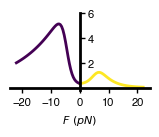

In [46]:
fcolors =  cm.viridis(np.linspace(0, 1, 7))
F_neg_plot = -1*F_neg 
plt.figure(1,figsize=(1.8,1))
plt.plot(F_pos, tau_vs_force_pos, color=fcolors[-1], label='Force towards barbed end')
plt.plot(F_neg_plot, tau_vs_force_neg,  color=fcolors[0], label='Force towards pointed end')
#plt.xlabel(r'$F \ (pN)$')
#plt.ylabel(r'$\tau \ (s)$')
ax = plt.gca()
ax.spines['left'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Hide x-axis spine
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis="y",direction="in", pad=-10)

#ax.set_ylabel(r'$\tau \ (s)$', direction='in')


ax.spines['bottom'].set_position('zero')
plt.xticks(np.arange(-20, 21, 10))

# Hide the tick at 0 for the y-axis
plt.yticks(np.arange(2, 7, 2))

#plt.legend(fontsize=12)
ax.set_xlabel(r'$F \ (pN)$',  size=8)
ax.tick_params(axis='both', labelsize=8, width=1)
#plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3,hspace=0.45)
#plt.tight_layout()
plt.savefig(f"{figure_dir}/best_fit_model_exp_v4_center.pdf", bbox_inches='tight', format='pdf' )
plt.show()